# Validation cases for new wake models: 

In [2]:
from MITWake import Wake
import numpy as np
import matplotlib.pyplot as plt
import padeopsIO as pio
import pandas as pd
%load_ext autoreload
%autoreload 2


cts = [0.824, 0.788, 0.737, 0.665]
TI = 0.075
yaws = -np.deg2rad(np.arange(0, 31, 10))
BP = [Wake.GaussianBP(ct, yaw, TI=TI, ky=0.022) for ct, yaw in zip(cts, yaws)]
df = pd.DataFrame(data={'ct': cts, 'yaw': yaws, 'BP': BP})

In [105]:
BP_data = pd.read_csv(r'C:\Users\kirby\OneDrive - Massachusetts Institute of Technology\01_MIT\howland\data\extracted\BP2016\fig21_yaw20.csv', header=None)


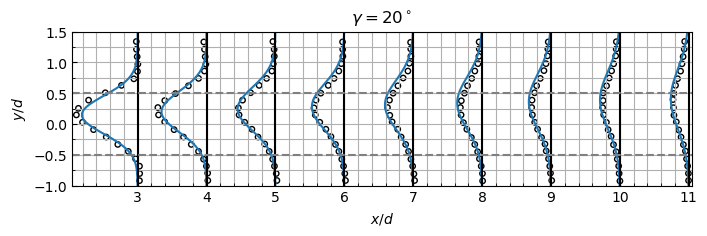

x0 length: 4.0d


In [106]:
from matplotlib.ticker import MultipleLocator

for k, row in df.iterrows(): 
    if not k == 2: 
        continue

    x = np.arange(3, 12, 1)
    y = np.linspace(-1, 1.5)
    du_xy = row['BP'].deficit(x=x[:, None], y=y[None, :], z=0)

    # it says that 1 x/D -> 0.75 u/u_hub in the figure caption... 
    fig, ax = plt.subplots(figsize=(8, 2))
    for xi in range(len(x)): 
        x_plt = x[xi] + 1/0.75 * (-du_xy[xi, :]) 
        ax.plot(x_plt, y, color='tab:blue')
        ax.grid(which='both')

    ax.scatter(BP_data[0], BP_data[1], edgecolors='k', facecolors='none', s=15)
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    ax.tick_params(which='both', direction='in')

    for xi in x: 
        ax.axvline(xi, color='k')
    ax.axhline(0.5, color='gray', ls='--')
    ax.axhline(-0.5, color='gray', ls='--')
    ax.set_xlabel('$x/d$')
    ax.set_ylabel('$y/d$')
    ax.set_title('$\\gamma = {:.0f}^\circ$'.format(row['yaw'] * 180/np.pi))
    ax.set_xlim([2.05, 11.05])
    ax.set_ylim([-1, 1.5])
    plt.show()
    print('x0 length: {:.1f}d'.format(row['BP'].x0))

# this looks correct; BP2016 looks great. 

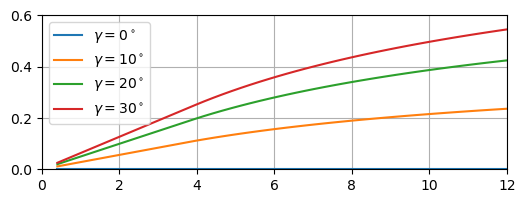

In [107]:
x = np.linspace(0.4, 12)
fig, ax = plt.subplots(figsize=(6, 2))
for k, row in df.iterrows(): 
    ax.plot(x, row['BP'].centerline(x), label='$\\gamma = {:.0f}^\circ$'.format(row['yaw'] * 180/np.pi))

ax.set_xlim([0, 12])
ax.set_ylim([0, 0.6])
ax.grid()
ax.legend()
plt.show()

# these match plots from QI2018 for BP2016

## Curled wake model 

In [3]:
from MITWake import CurledWake

ct = 8./9
yaw = np.deg2rad(0)

wake = CurledWake.CurledWake(ct, yaw)
# x, u_field = wake.compute_u()

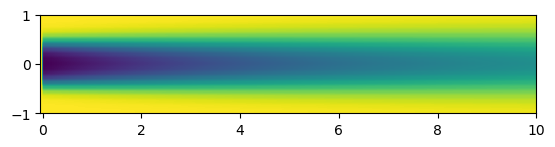

In [4]:
(u_field, _, _) = wake.compute_uvw(x=[0, 10], y=0, z=0, return_uvw=True, nu_eff=0.004)
zid = np.argmin(abs(wake.zg))
xid = np.argmin(abs(wake.xg-0.))

fig, ax = plt.subplots()
ax.imshow(u_field[..., zid].T, origin='lower', extent=wake.extent[:4])
# ax.imshow(u_field[xid, ...].T, origin='lower', extent=wake.extent[2:])
plt.show()

In [61]:
ct = 0.56 #8./9
yaw = np.deg2rad(30)

wake = CurledWake.CurledWake(ct, yaw, dy=0.05, dz=0.05, dx=0.025, N=20)


In [66]:
(u, v, w) = wake.compute_uvw(x=[-2, 10], y=[-1.5, 1.5], z=[-1.5, 1.5], return_uvw=True, nu_eff=1e-4)#5e-4)


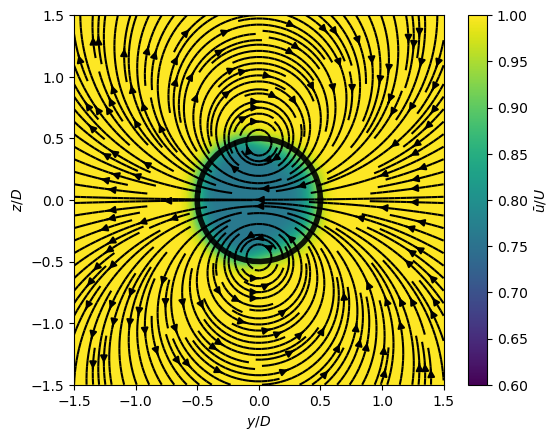

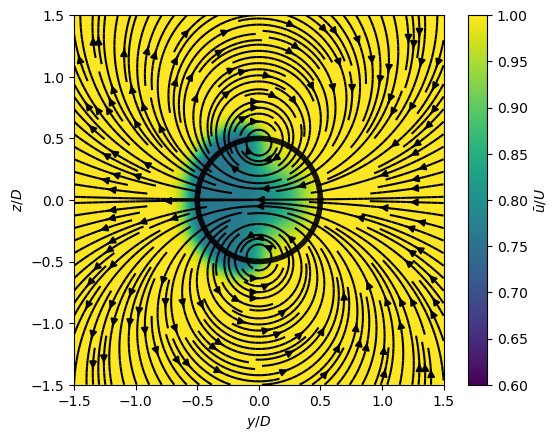

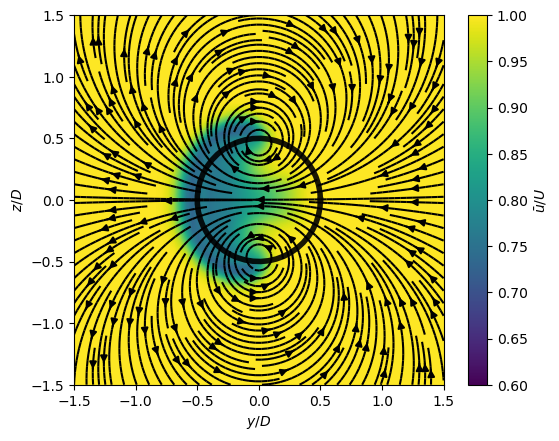

In [67]:
zid = np.argmin(abs(wake.zg))

for xval in [1, 5, 8]: 
    xid = np.argmin(abs(wake.xg-xval))

    theta = np.linspace(0, 2*np.pi)
    r = wake.d / 2.
    yt = np.cos(theta) * r
    zt = np.sin(theta) * r

    fig, ax = plt.subplots()
    # ax.imshow(u[..., zid].T, origin='lower', extent=wake.extent[:4])
    im = ax.imshow(1 + u[xid, ...].T, origin='lower', extent=wake.extent[2:], clim = [0.6, 1], interpolation='bilinear')
    ax.streamplot(wake.yg, wake.zg, v[xid, ...].T, w[xid, ...].T, color='k', density=2)
    # ax.scatter(r_i*0, r_i, edgecolor='k', facecolor='none')
    ax.plot(yt, zt, color='k', alpha=0.9, lw=4)
    plt.colorbar(im, label='$\\bar{u}/U$')
    ax.set_xlabel('$y/D$')
    ax.set_ylabel('$z/D$')
    plt.show()

Some tests in non-uniform inflow: 

In [5]:
# basedir = r'C:\Users\kirby\OneDrive - Massachusetts Institute of Technology\01_MIT\howland\data\CNBL_Ro'
# name = 'r1'
basedir = r'G:\Shared drives\howland_lab\current_projects\2022_harrington_urop\LES_data\two_turbine_sweep\export3'
name = 'yaw_06_cT_09'


pri = pio.BudgetIO(basedir, filename=name, mat=True)
pre = pio.BudgetIO(basedir, filename='yaw_04_ct_05_precursor', mat=True)

adm = pri.turbineArray.turbines[0]
ct = 8./9  # estimate
yaw = np.deg2rad(adm.yaw)
zh = adm.zloc
wake = CurledWake.CurledWake(ct, yaw, bkgd=pre, z_hub=zh, dy=pre.dy, dz=pre.dz, C=1)

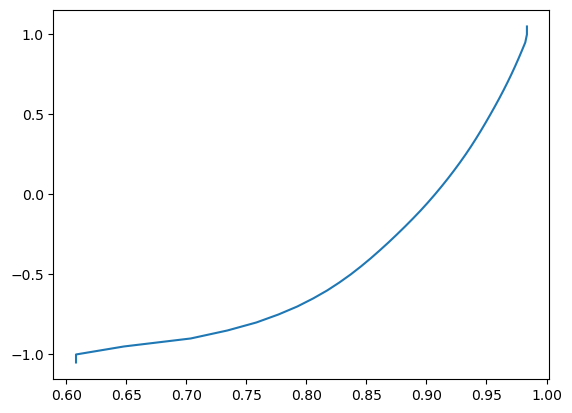

In [6]:
plt.plot(wake.U, wake.zg)  # beautiful ABL profile... 

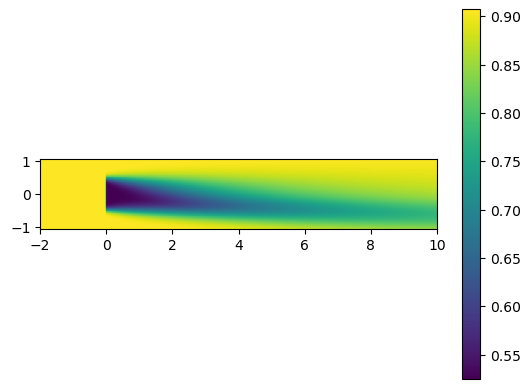

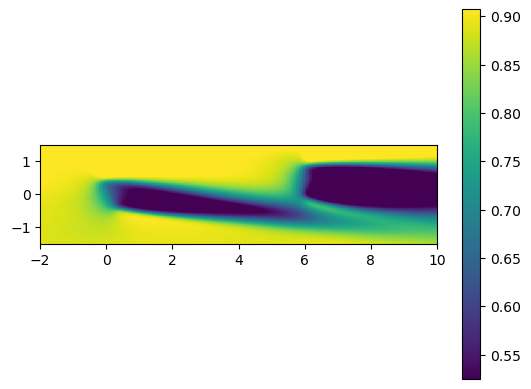

In [8]:
wake.C = 4
(u_field, _, _) = wake.compute_uvw(x=[-2, 10], y=0, z=0, return_uvw=True)
zid = np.argmin(abs(wake.zg))
xval = 5

xid = np.argmin(abs(wake.xg-xval))

fig, ax = plt.subplots()
im = ax.imshow((wake.U[zid] + u_field[..., zid]).T, origin='lower', extent=wake.extent[:4])
# im = ax.imshow((wake.U[None, :] + u_field[xid, ...]).T, origin='lower', extent=wake.extent[2:])
plt.colorbar(im)
plt.show()  # HEY that's a wake! 

fig, ax = plt.subplots()
sl = pri.slice(budget_terms=['ubar'], xlim=[-2, 10], ylim=[-1.5, 1.5], zlim=0)
# sl = pri.slice(budget_terms=['ubar'], xlim=xval, ylim=[np.min(wake.yg), np.max(wake.yg)], zlim=[np.min(wake.zg), np.max(wake.zg)])
im2 = ax.imshow(sl['ubar'].T, origin='lower', extent=sl['extent'], clim=im.get_clim())

plt.colorbar(im2)
plt.show()

### Random testing: 


In [5]:
# test interpn: 
from scipy.interpolate import interpn

pri.read_budgets(budget_terms=['ubar'])
points = (pri.xLine, pri.yLine, pri.zLine)
values = pri.budget['ubar']


In [38]:
xi = np.tile(np.array([2.11, 1.11, 1.11]).T, (10, 1))
interpn(points, values, xi)

array([1.02440093, 1.02440093, 1.02440093, 1.02440093, 1.02440093,
       1.02440093, 1.02440093, 1.02440093, 1.02440093, 1.02440093])

So we can interpolate the result in this way. 

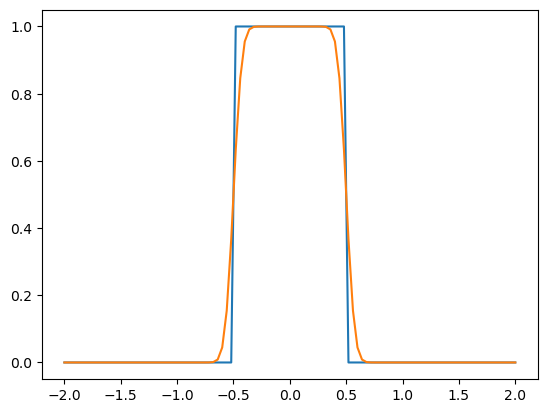

In [63]:
x = np.linspace(-2, 2, 101)
turbine = np.zeros_like(x)
turbine[np.abs(x) < 0.5] = 1

dx = x[1]-x[0]
alpha = 1.5
gauss = np.exp(-(x / (dx * alpha)) ** 2 / 2)  # / (dx * alpha * np.sqrt(2 * np.pi))
gauss /= sum(gauss)
smooth = np.convolve(turbine, gauss, 'same')

fig, ax = plt.subplots()
ax.plot(x, turbine)
ax.plot(x, smooth)

plt.show()  # smoothed kernel

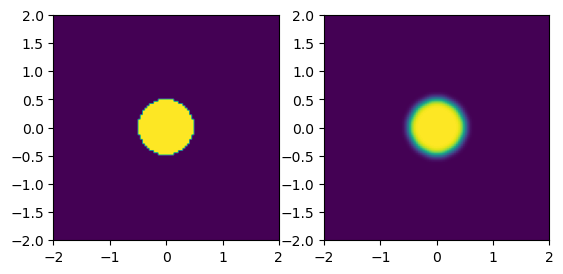

In [73]:
# in 2D: 
from scipy.signal import convolve2d

xG, yG = np.meshgrid(x, x, indexing='ij')
turbine = (xG**2 + yG**2) < 0.5**2
gauss2 = np.exp(-(xG**2 + yG**2) / (dx * alpha)**2 / 2)
gauss2 /= np.sum(gauss2)
smooth = convolve2d(turbine, gauss2, 'same')
ext = [min(x), max(x)] * 2

fig, axs = plt.subplots(ncols=2)
axs[1].imshow(smooth.T, origin='lower', clim=[0, 1], extent=ext)
axs[0].imshow(turbine.T, origin='lower', clim=[0, 1], extent=ext)
plt.show()  # seems reasonable

In [101]:
# axis creation
xmin = -1
xmax = 5.61
dx = 0.05

n = np.ceil(np.diff([xmin, xmax]) / dx)
n_st = np.ceil(np.abs(xmin / dx)) * np.sign(xmin)
n_end = np.ceil(np.abs(xmax / dx)) * np.sign(xmax)
x = np.arange(n_st, n_end + dx) * dx
x

array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
       -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
        0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,
        0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,
        1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,
        1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,
        2.15,  2.2 ,  2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,
        2.6 ,  2.65,  2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,
        3.05,  3.1 ,  3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,
        3.5 ,  3.55,  3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,
        3.95,  4.  ,  4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,
        4.4 ,  4.45,  4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,
        4.85,  4.9 ,  4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,
        5.3 ,  5.35,

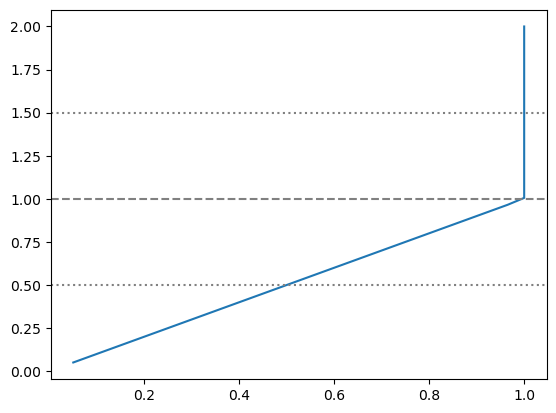

In [144]:
# test getting disk velocity: 

z = np.linspace(0.05, 2)
z0 = 1e-5
u_star = 0.029
kappa = 0.40
# U_z = np.log(z/z0) * u_star/kappa
U_z = z * (z < 1) + 1 * (z > 1)

fig, ax = plt.subplots()
ax.plot(U_z, z)
ax.axhline(1, color='gray', ls='--')
ax.axhline(1.5, color='gray', ls=':')
ax.axhline(0.5, color='gray', ls=':')
plt.show()

In [145]:
zt = z - 1  # hub-aligned axis
r = 0.5
zids = abs(zt) < r
dz = z[1]-z[0]

# easy integration: 
ud_easy = np.mean(U_z[zids])
print(ud_easy)

# weighted integration
ud_weighted = np.trapz(U_z[zids] * np.sqrt(r**2 - zt[zids]**2)) / np.trapz(np.sqrt(r**2 - zt[zids]**2)) 
print(ud_weighted)


0.8782857142857142
0.8966512653865524
